<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/Player_roles_passing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# File paths (adjust these paths as needed)
input_file = '/content/drive/My Drive/BM2425.xlsx'  # Replace with your input file path
output_file = '/content/drive/My Drive/pass_directions_with_roles.xlsx'  # Replace with your desired output file path

# Load the data from the Excel file
data = pd.read_excel(input_file)

# Ensure the necessary columns are present
required_columns = {'playerName', 'x', 'y', 'endX', 'endY'}
if not required_columns.issubset(data.columns):
    raise ValueError(f"Input file must contain the following columns: {required_columns}")

# Define a function to calculate pass direction
def calculate_direction(start_x, start_y, end_x, end_y):
    dx = end_x - start_x
    dy = end_y - start_y

    if dx == 0 and dy == 0:
        return 'stationary'
    elif dx == 0:
        return 'lateral'
    elif dy == 0:
        return 'back' if dx < 0 else 'forward'
    elif dx < 0 and dy < 0:
        return 'back'
    elif dx > 0 and dy > 0:
        return 'forward'
    else:
        return 'diagonal'

# Apply the direction calculation to each row
data['direction'] = data.apply(lambda row: calculate_direction(row['x'], row['y'], row['endX'], row['endY']), axis=1)

# Group by playerName and count the occurrences of each direction
direction_counts = data.groupby(['playerName', 'direction']).size().unstack(fill_value=0)

# Calculate z-scores for each direction
z_scores = (direction_counts - direction_counts.mean()) / direction_counts.std()

# Define weights for each direction
weights = {
    'forward': 1.5,
    'back': 1.0,
    'lateral': 1.2,
    'diagonal': 1.3,
    'stationary': 0.8
}

# Apply weights to z-scores
for direction, weight in weights.items():
    if direction in z_scores.columns:
        z_scores[direction] *= weight

# Scale z-scores to a range of 0-100
scaled_scores = z_scores.copy()
for col in z_scores.columns:
    min_z = z_scores[col].min()
    max_z = z_scores[col].max()
    scaled_scores[col] = (z_scores[col] - min_z) / (max_z - min_z) * 100

# Assign roles based on scaled scores
roles = []
for _, row in scaled_scores.iterrows():
    role_scores = {
        'Playmaker': row.get('forward', 0) + row.get('diagonal', 0),
        'Defender': row.get('back', 0) + row.get('lateral', 0),
        'Support': row.get('stationary', 0) + row.get('lateral', 0),
        'Attacker': row.get('forward', 0) * 1.2 + row.get('diagonal', 0) * 1.1
    }
    roles.append(max(role_scores, key=role_scores.get))

scaled_scores['role'] = roles

# Save the result to a new Excel file
scaled_scores.to_excel(output_file)

print(f"Pass direction analysis with roles has been saved to {output_file}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Pass direction analysis with roles has been saved to /content/drive/My Drive/pass_directions_with_roles.xlsx


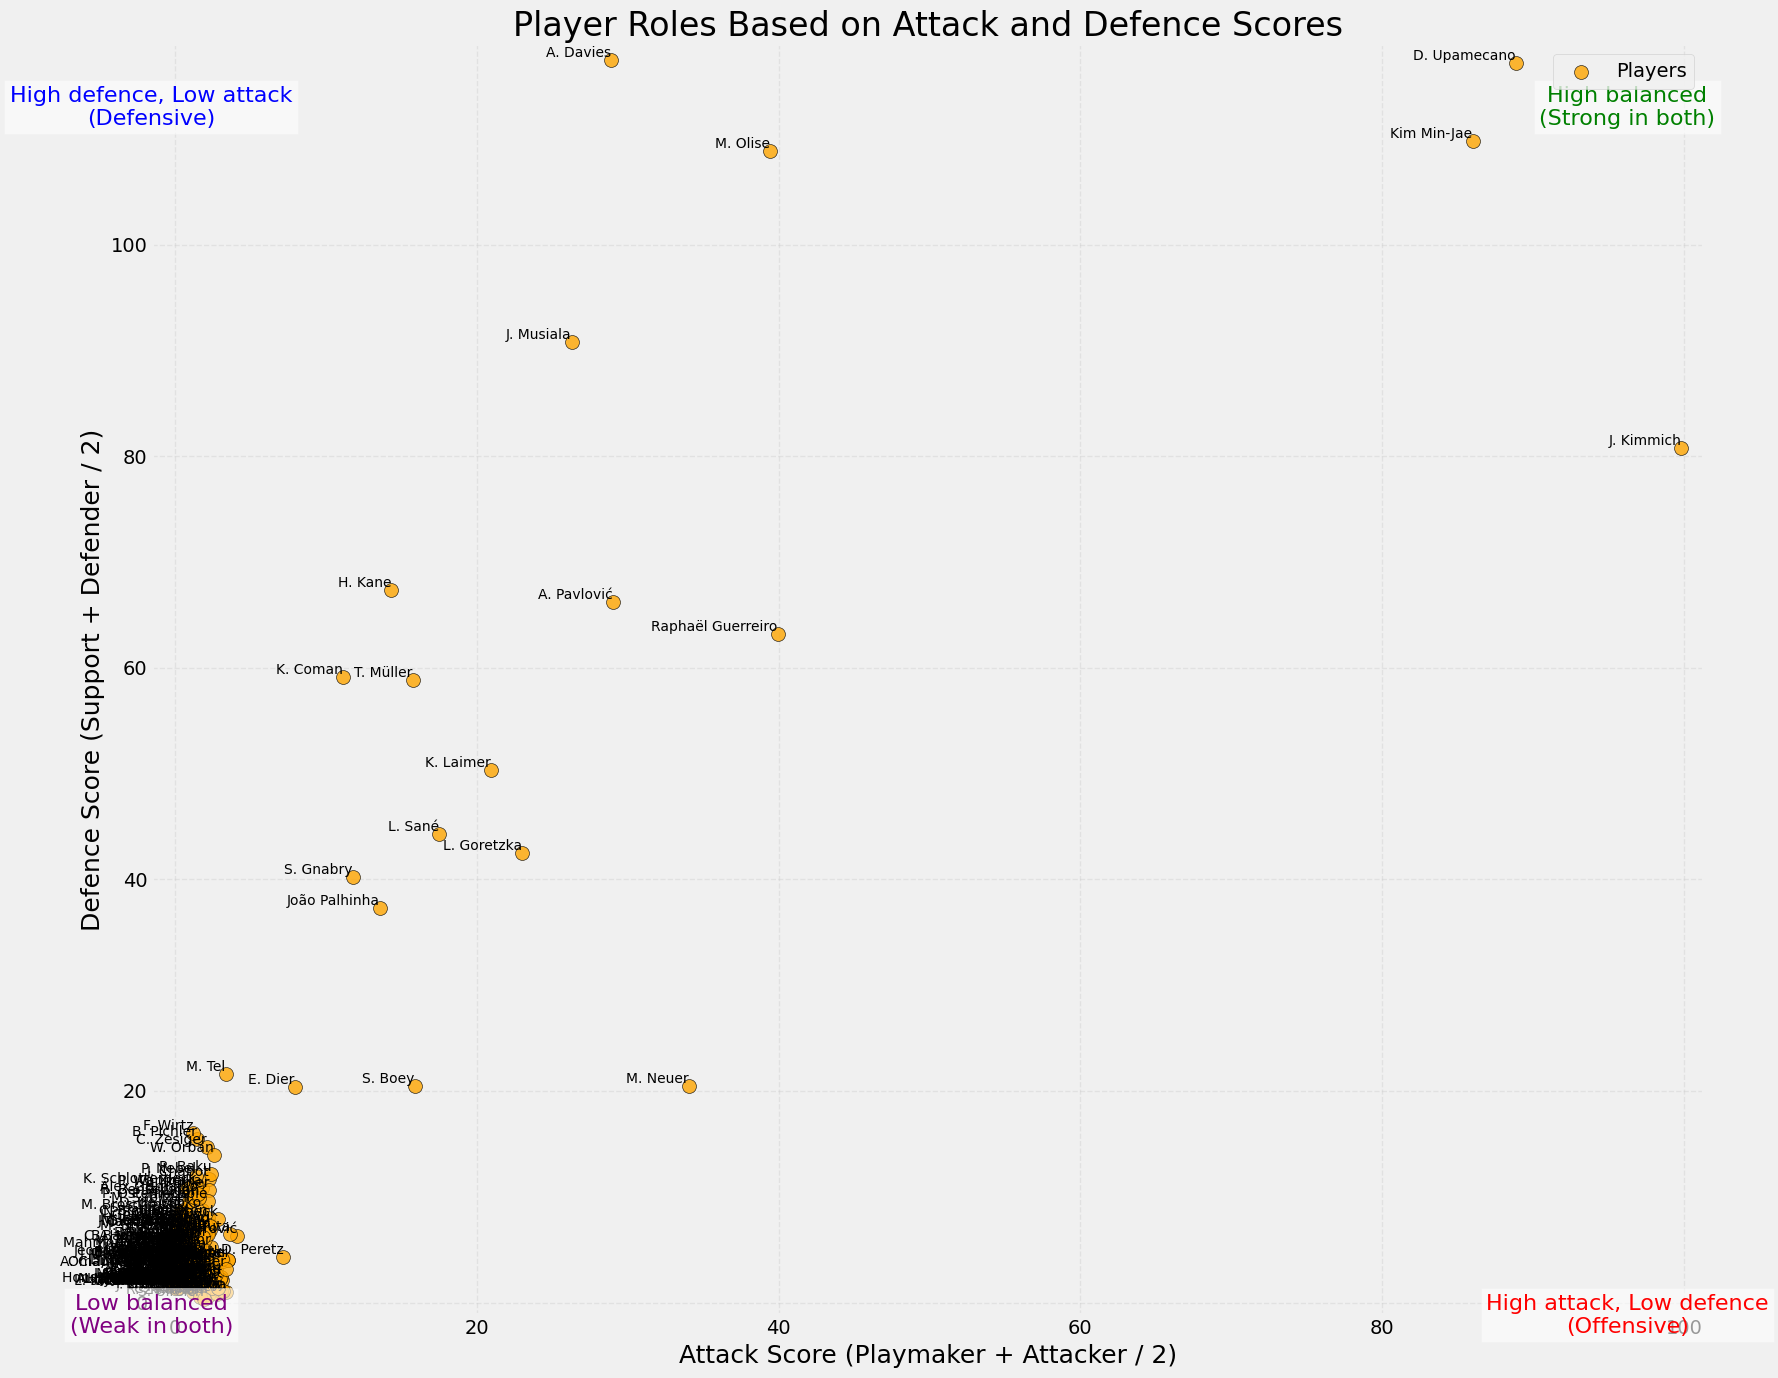

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load data from Excel (replace 'file_path.xlsx' with your actual file path)
file_path = '/content/drive/My Drive/pass_directions_with_roles.xlsx'
data = pd.read_excel(file_path)

# Prepare the scaled_scores DataFrame
scaled_scores = data.copy()  # Assuming 'data' already contains the necessary scaled data
scaled_scores['playerName'] = data['playerName']  # Player names come directly from the file

# Calculate new Attack and Defence scores as averages
scaled_scores['Attack_Score'] = (scaled_scores['forward'] + scaled_scores['diagonal'] * 1.1) / 2  # Playmaker + Attacker
scaled_scores['Defence_Score'] = (scaled_scores['stationary'] + scaled_scores['lateral'] + scaled_scores['back']) / 2  # Support + Defender

# Apply a FiveThirtyEight style
def apply_fivethirtyeight_style():
    plt.style.use('fivethirtyeight')

apply_fivethirtyeight_style()

# Create scatter plot
plt.figure(figsize=(18, 14))  # Further increased figure size
plt.scatter(
    scaled_scores['Attack_Score'],
    scaled_scores['Defence_Score'],
    alpha=0.8,
    color='orange',
    edgecolor='black',
    s=100,  # Increased marker size for better visibility
    label='Players'
)

# Add labels to each scatter point
for i, row in scaled_scores.iterrows():
    plt.text(
        row['Attack_Score'],
        row['Defence_Score'],
        row['playerName'],
        fontsize=10,  # Slightly larger font size for better readability
        ha='right',
        va='bottom'
    )

# Define the ranges for visualization
plt.xlim(scaled_scores['Attack_Score'].min() - 1.5, scaled_scores['Attack_Score'].max() + 1.5)
plt.ylim(scaled_scores['Defence_Score'].min() - 1.5, scaled_scores['Defence_Score'].max() + 1.5)

# Add role labels to corners
x_range = plt.xlim()
y_range = plt.ylim()

plt.text(x_range[1] * 0.95, y_range[1] * 0.95, 'High balanced\n(Strong in both)', fontsize=16, color='green', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6))
plt.text(x_range[1] * 0.95, y_range[0] * 1.05, 'High attack, Low defence\n(Offensive)', fontsize=16, color='red', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6))
plt.text(x_range[0] * 1.05, y_range[1] * 0.95, 'High defence, Low attack\n(Defensive)', fontsize=16, color='blue', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6))
plt.text(x_range[0] * 1.05, y_range[0] * 1.05, 'Low balanced\n(Weak in both)', fontsize=16, color='purple', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6))

# Label axes and title
plt.xlabel('Attack Score (Playmaker + Attacker / 2)', fontsize=18)
plt.ylabel('Defence Score (Support + Defender / 2)', fontsize=18)
plt.title('Player Roles Based on Attack and Defence Scores', fontsize=24)

# Enhance plot aesthetics
plt.grid(alpha=0.4, linestyle='--')  # Dashed grid lines for better aesthetics
plt.legend(fontsize=14, loc='upper right')
plt.tight_layout()

# Show plot
plt.show()


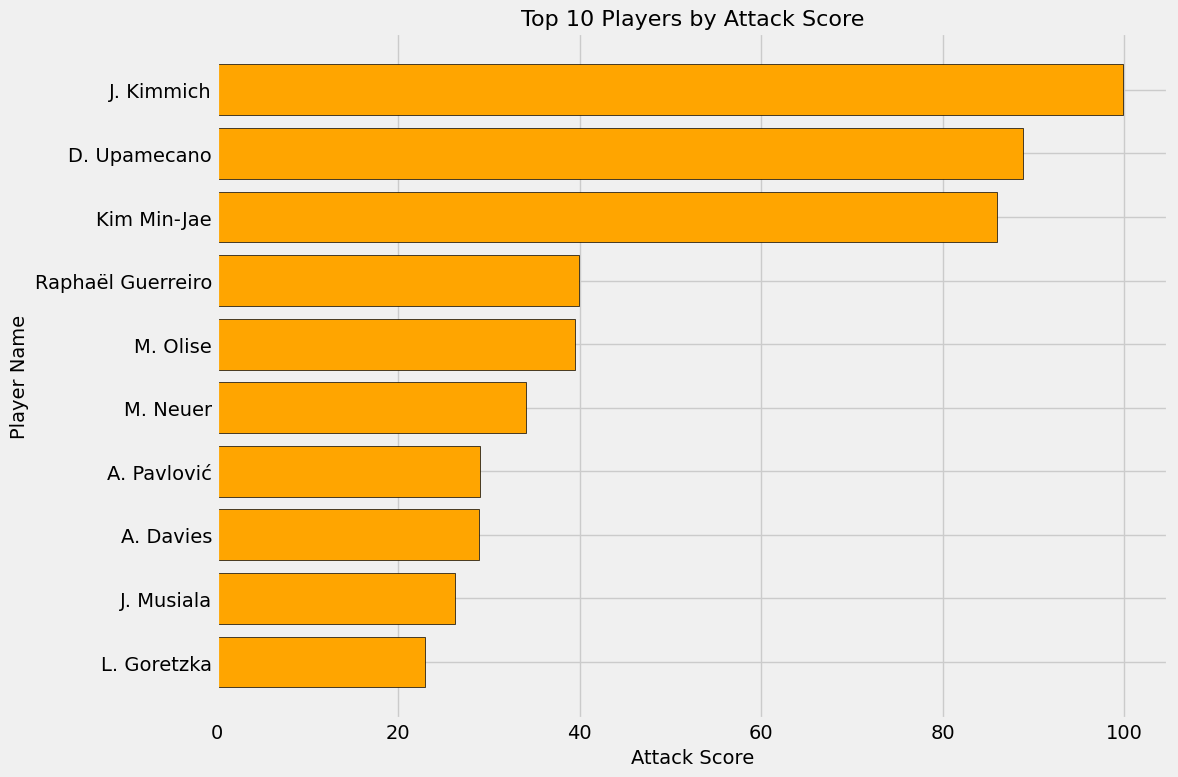

In [ ]:
# Sort by Attack_Score
top_attackers = scaled_scores.sort_values(by='Attack_Score', ascending=False).head(10)

# Plot bar chart
plt.figure(figsize=(12, 8))
plt.barh(top_attackers['playerName'], top_attackers['Attack_Score'], color='orange', edgecolor='black')
plt.xlabel('Attack Score', fontsize=14)
plt.ylabel('Player Name', fontsize=14)
plt.title('Top 10 Players by Attack Score', fontsize=16)
plt.gca().invert_yaxis()  # Invert Y-axis for better readability
plt.tight_layout()
plt.show()


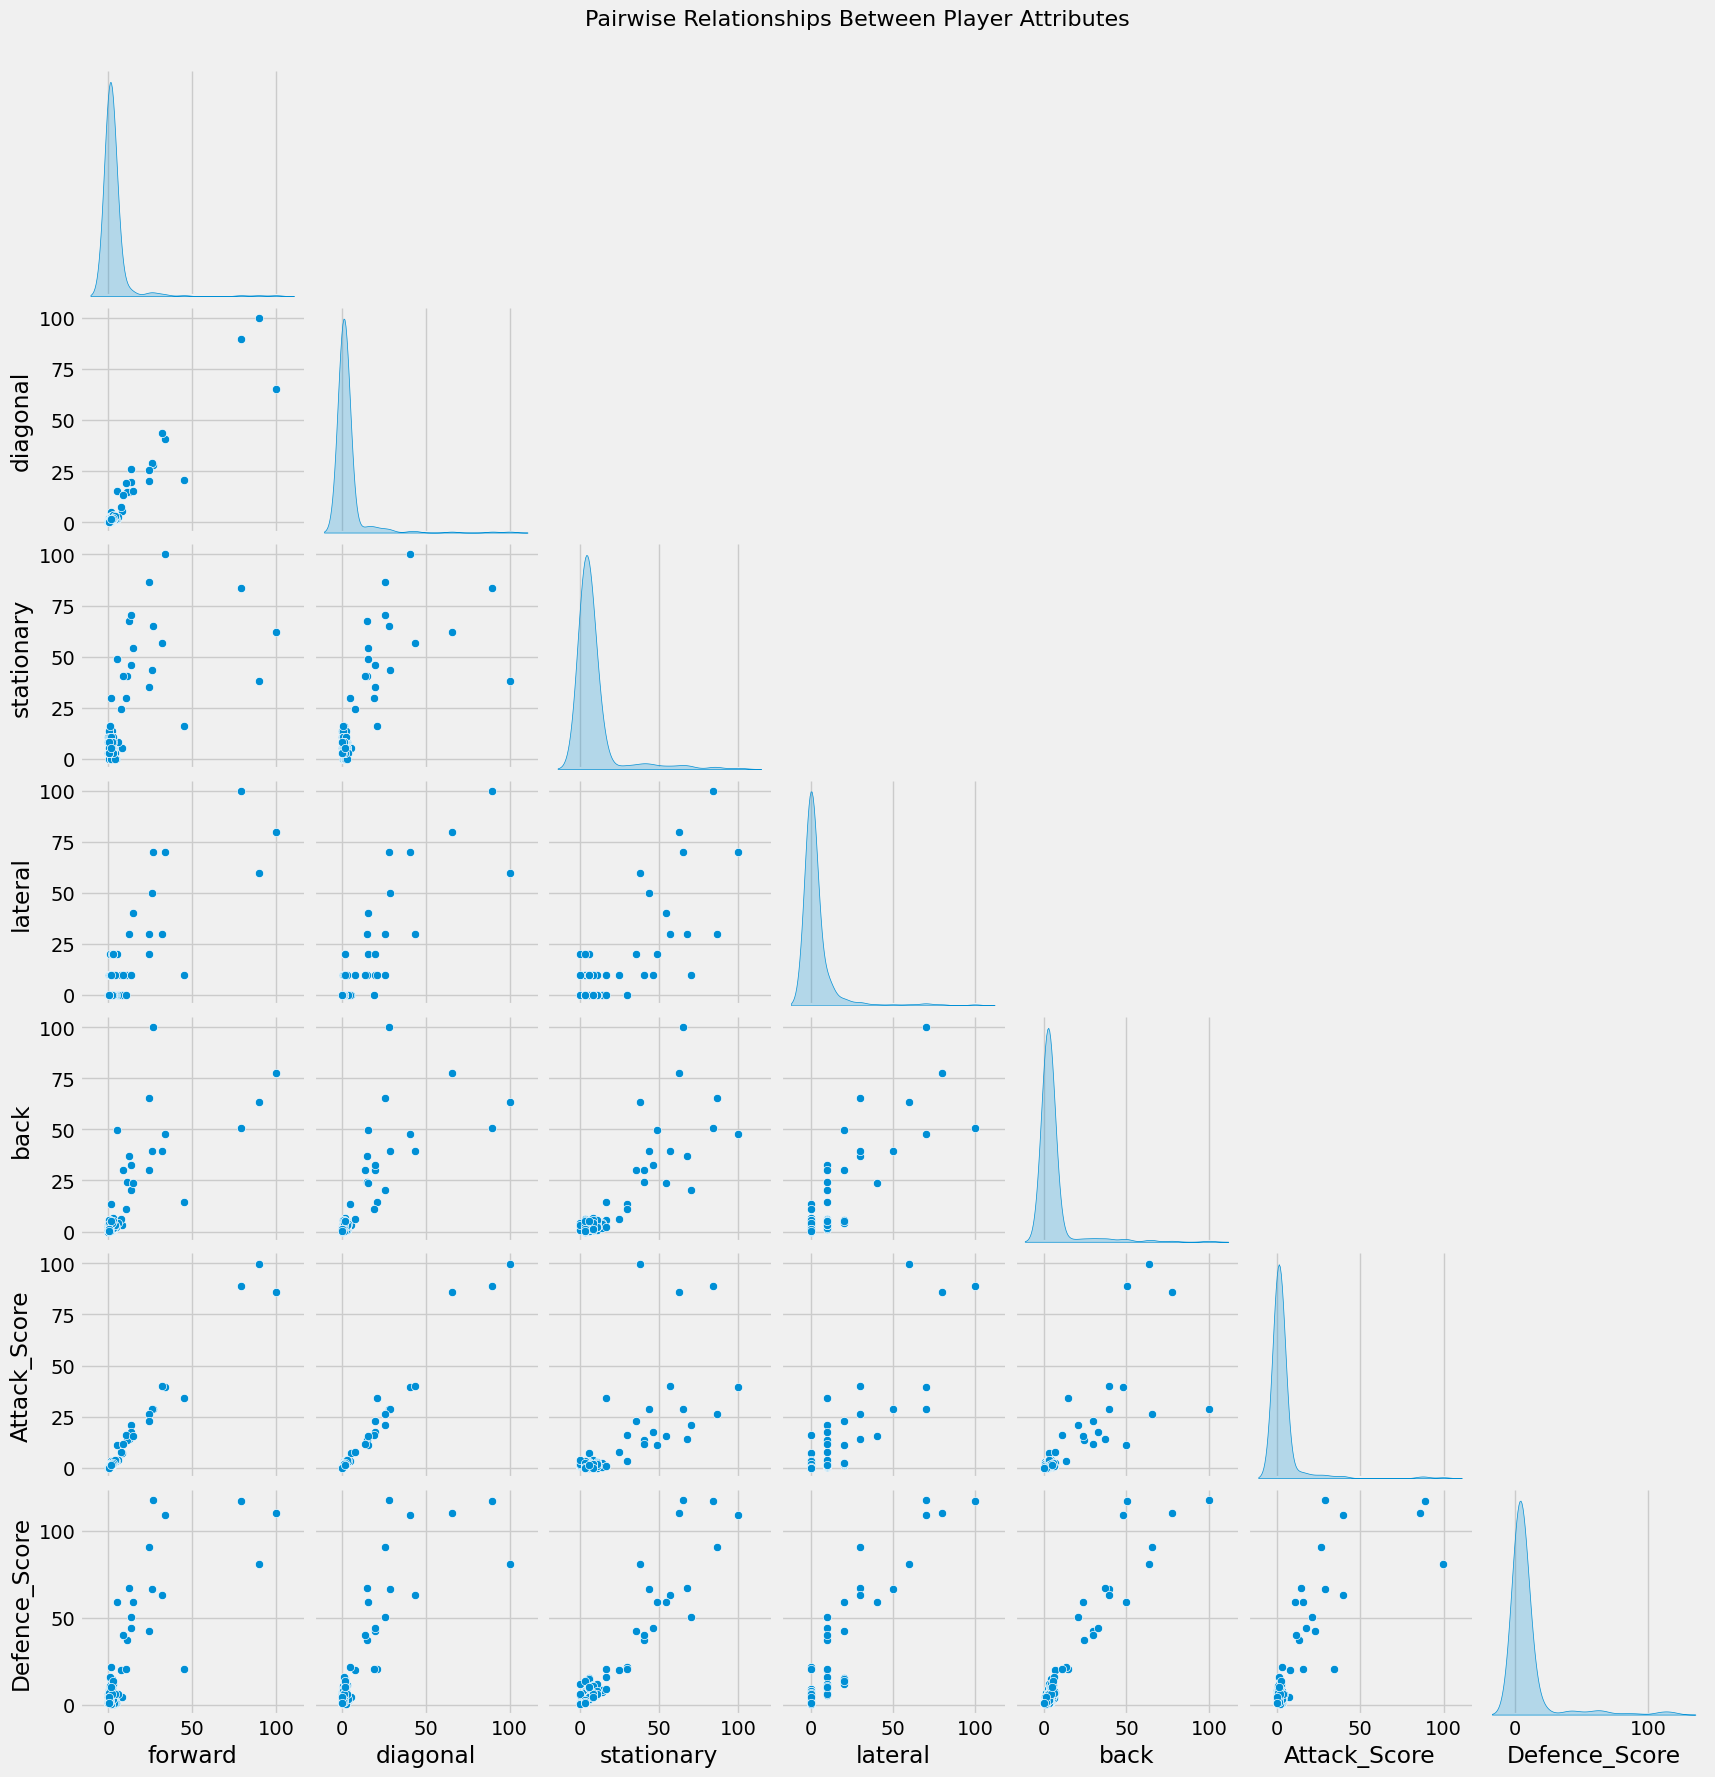

In [ ]:
import seaborn as sns

# Pairplot for selected features
selected_features = ['forward', 'diagonal', 'stationary', 'lateral', 'back', 'Attack_Score', 'Defence_Score']
sns.pairplot(scaled_scores[selected_features], diag_kind="kde", corner=True)
plt.suptitle('Pairwise Relationships Between Player Attributes', y=1.02, fontsize=16)
plt.show()


<ipython-input-17-bf22541a9c26>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=scores, x='Score Type', y='Score', palette="muted", inner="quartile")


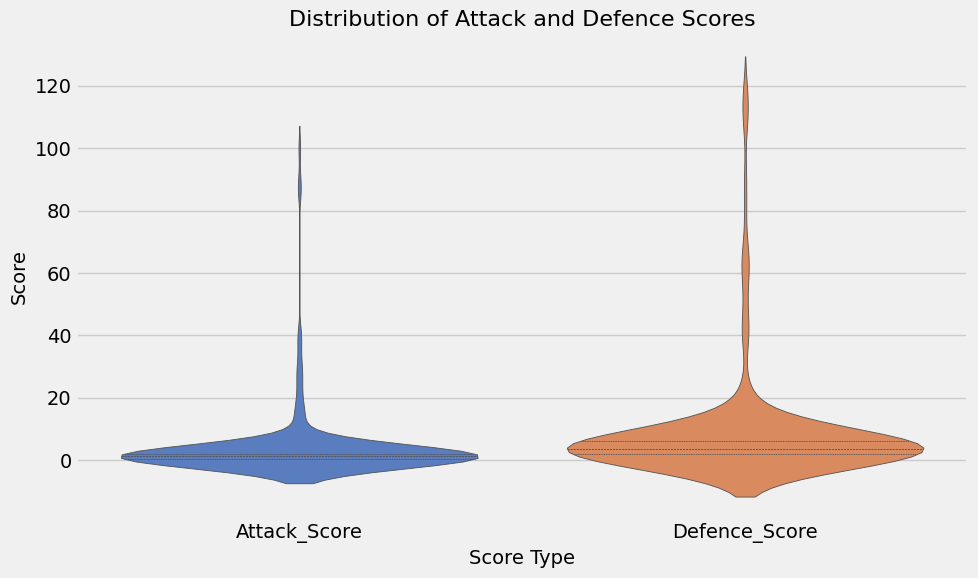

In [ ]:
import seaborn as sns

# Combine scores for grouping
scores = pd.melt(scaled_scores, id_vars=['playerName'], value_vars=['Attack_Score', 'Defence_Score'], var_name='Score Type', value_name='Score')

# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=scores, x='Score Type', y='Score', palette="muted", inner="quartile")
plt.title('Distribution of Attack and Defence Scores', fontsize=16)
plt.xlabel('Score Type', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.tight_layout()
plt.show()


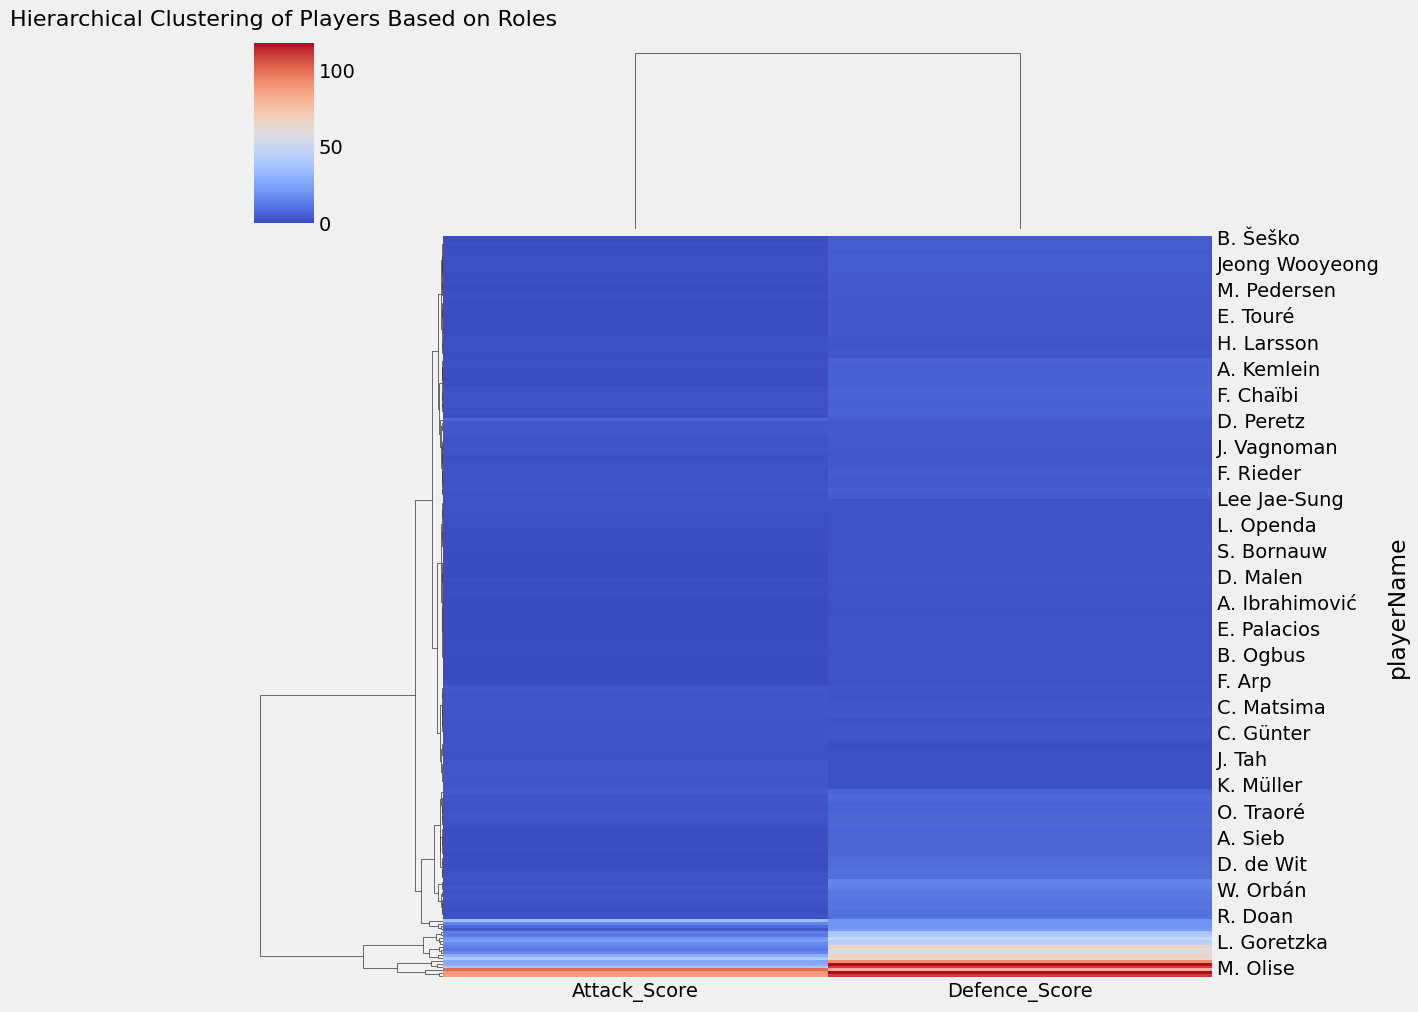

In [ ]:
import seaborn as sns

# Pivot data for clustering
cluster_data = scaled_scores[['playerName', 'Attack_Score', 'Defence_Score']].set_index('playerName')

# Cluster map
sns.clustermap(cluster_data, metric="euclidean", method="ward", cmap="coolwarm", figsize=(12, 10))
plt.title('Hierarchical Clustering of Players Based on Roles', fontsize=16, y=1.05)
plt.show()


<ipython-input-21-68d7676fef05>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scaled_scores['Attack_Score'], label='Attack Score', shade=True, color='orange')
<ipython-input-21-68d7676fef05>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scaled_scores['Defence_Score'], label='Defence Score', shade=True, color='blue')


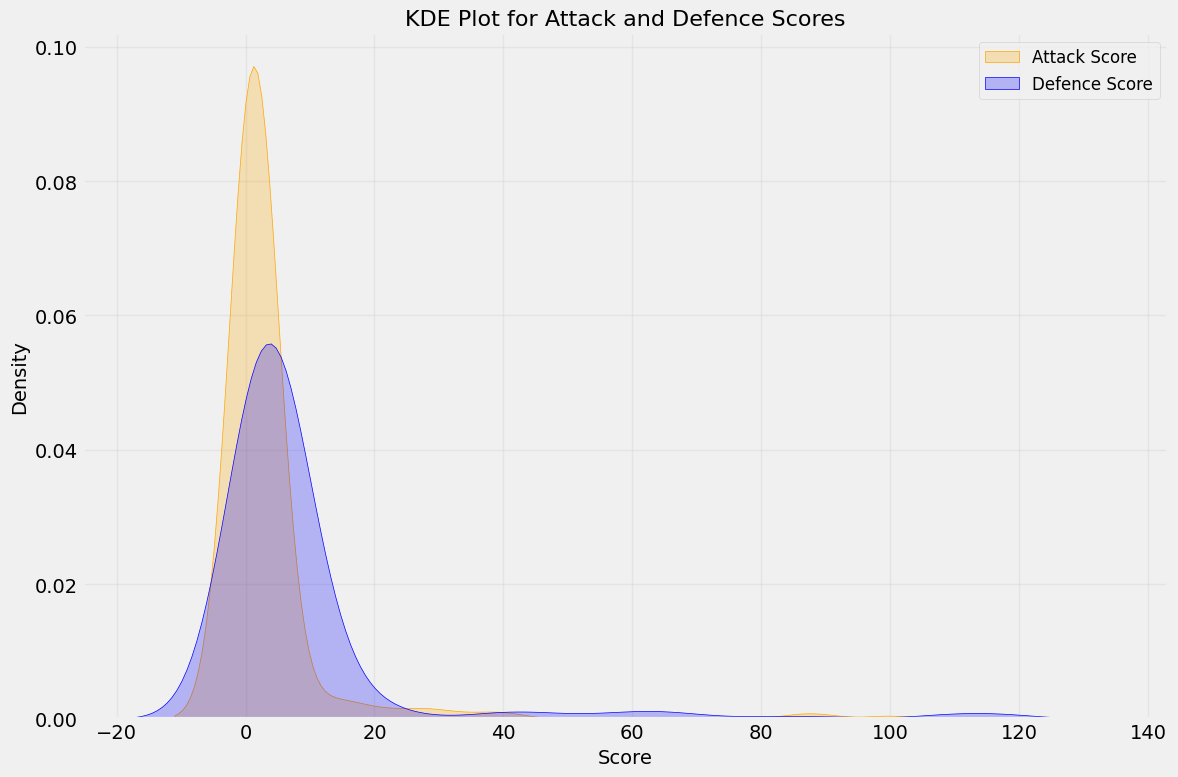

In [ ]:
import seaborn as sns

# KDE plot
plt.figure(figsize=(12, 8))
sns.kdeplot(scaled_scores['Attack_Score'], label='Attack Score', shade=True, color='orange')
sns.kdeplot(scaled_scores['Defence_Score'], label='Defence Score', shade=True, color='blue')
plt.title('KDE Plot for Attack and Defence Scores', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


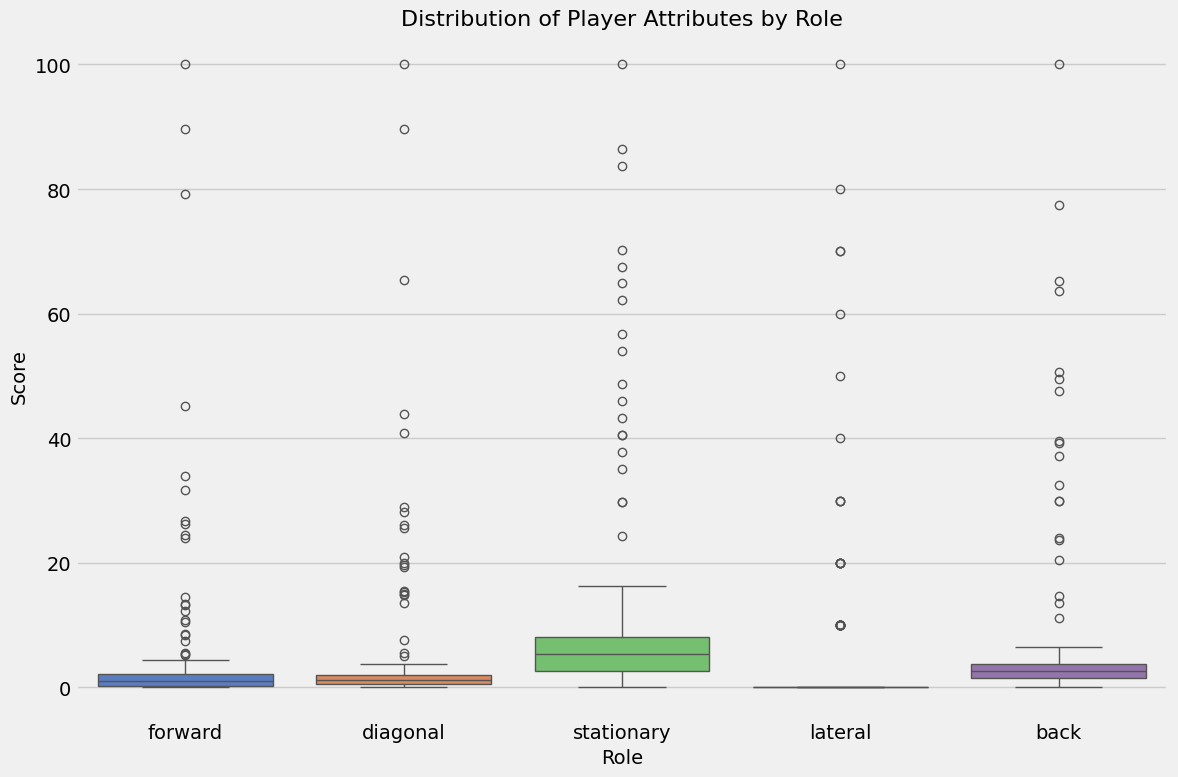

In [ ]:
# Prepare data for box plot
roles = ['forward', 'diagonal', 'stationary', 'lateral', 'back']
role_data = scaled_scores[roles]

# Box plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=role_data, palette="muted")
plt.title('Distribution of Player Attributes by Role', fontsize=16)
plt.xlabel('Role', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.tight_layout()
plt.show()


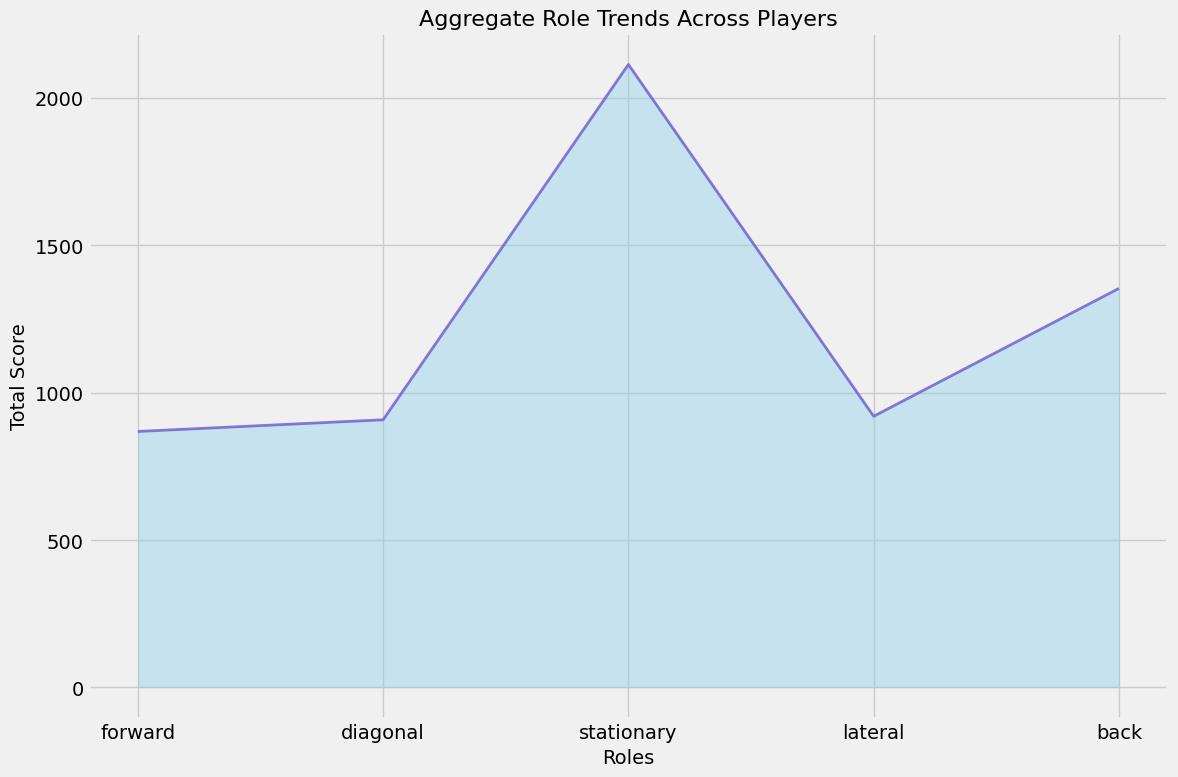

In [ ]:
# Aggregate scores by role
role_totals = scaled_scores[['forward', 'diagonal', 'stationary', 'lateral', 'back']].sum()

# Area plot
plt.figure(figsize=(12, 8))
plt.fill_between(role_totals.index, role_totals, color='skyblue', alpha=0.4)
plt.plot(role_totals.index, role_totals, color='Slateblue', alpha=0.8, linewidth=2)
plt.title('Aggregate Role Trends Across Players', fontsize=16)
plt.xlabel('Roles', fontsize=14)
plt.ylabel('Total Score', fontsize=14)
plt.tight_layout()
plt.show()


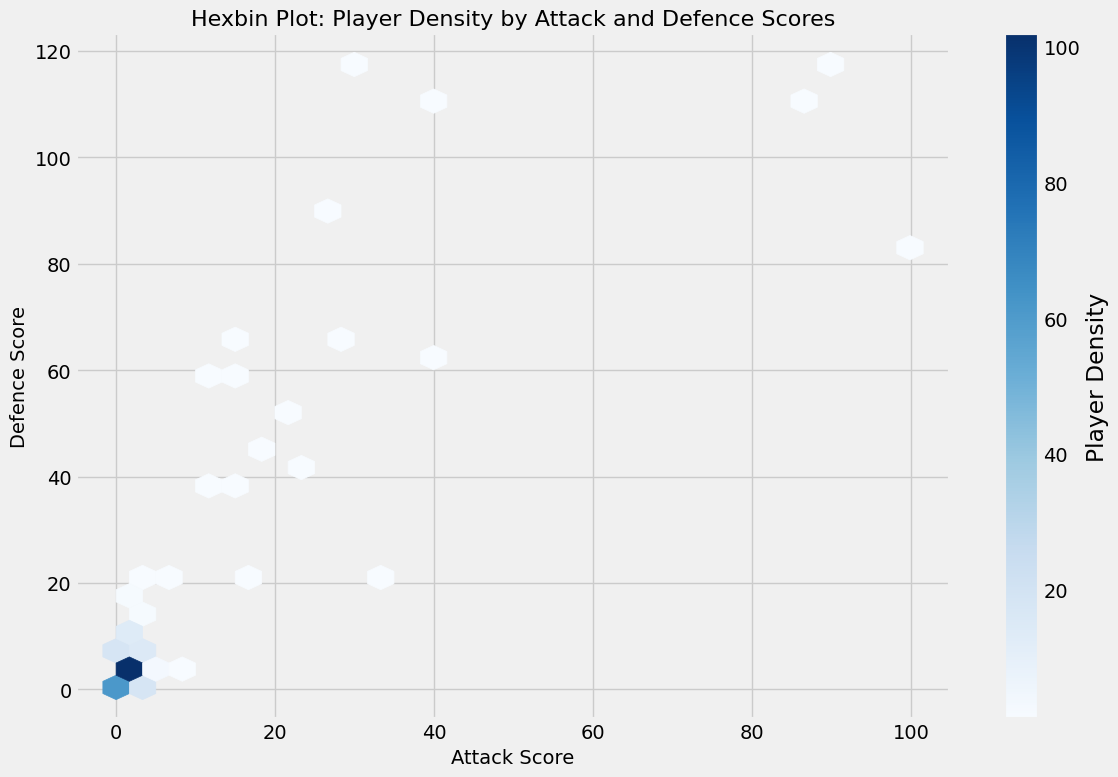

In [ ]:
# Hexbin plot
plt.figure(figsize=(12, 8))
plt.hexbin(
    scaled_scores['Attack_Score'],
    scaled_scores['Defence_Score'],
    gridsize=30,
    cmap='Blues',
    mincnt=1
)
plt.colorbar(label='Player Density')
plt.title('Hexbin Plot: Player Density by Attack and Defence Scores', fontsize=16)
plt.xlabel('Attack Score', fontsize=14)
plt.ylabel('Defence Score', fontsize=14)
plt.tight_layout()
plt.show()


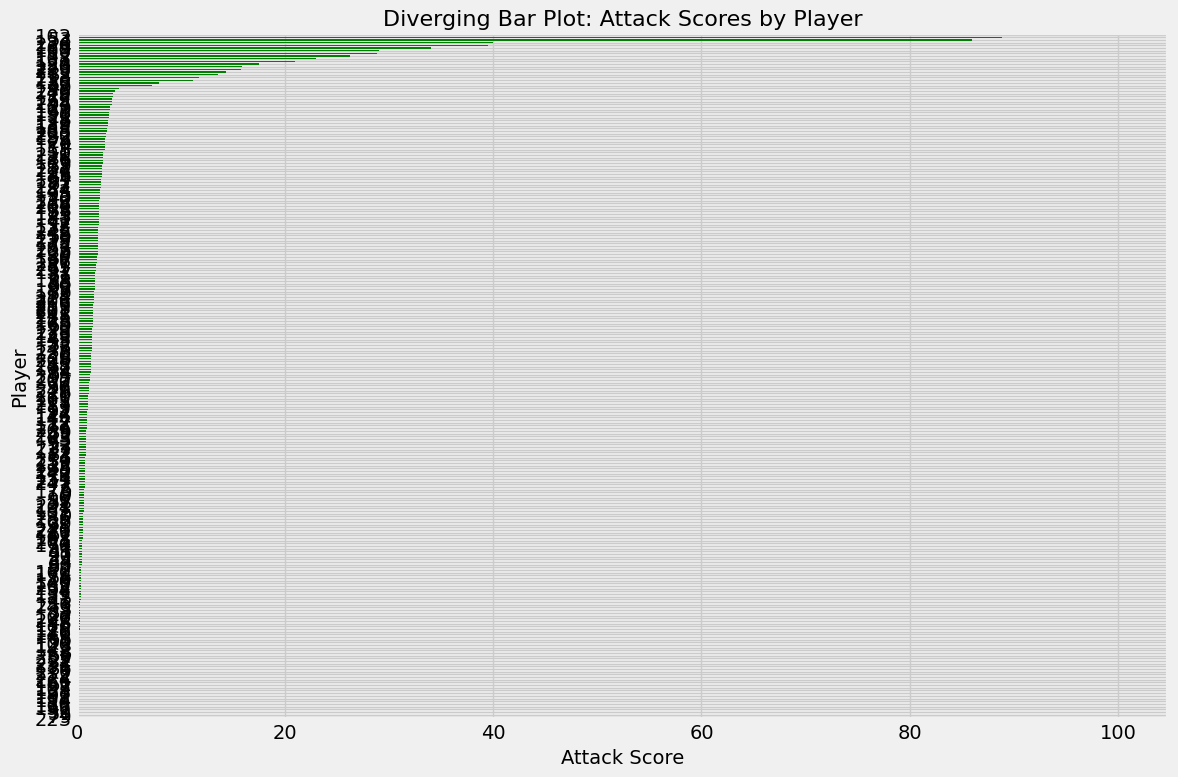

In [ ]:
# Sort players by Attack_Score
sorted_players = scaled_scores[['playerName', 'Attack_Score']].sort_values(by='Attack_Score')

# Diverging bar plot
plt.figure(figsize=(12, 8))
sorted_players['Attack_Score'].plot(kind='barh', color=sorted_players['Attack_Score'].apply(lambda x: 'red' if x < 0 else 'green'))
plt.title('Diverging Bar Plot: Attack Scores by Player', fontsize=16)
plt.xlabel('Attack Score', fontsize=14)
plt.ylabel('Player', fontsize=14)
plt.tight_layout()
plt.show()
